**Анализ бизнес показателей развлекательного приложения Procrastinate Pro+**

  Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
  - лог сервера с данными об их посещениях,  
  - выгрузка их покупок за этот период,  
  - рекламные расходы.
  
Необходимо определить: 
  
  - откуда приходят пользователи и какими устройствами они пользуются,  
  - сколько стоит привлечение пользователей из различных рекламных каналов;  
  - сколько денег приносит каждый клиент,  
  - когда расходы на привлечение клиента окупаются,  
  - какие факторы мешают привлечению клиентов.  

**Описание данных**

В нашем распоряжении три датасета.   
Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:  
User Id — уникальный идентификатор пользователя,  
Region — страна пользователя,  
Device — тип устройства пользователя,  
Channel — идентификатор источника перехода,  
Session Start — дата и время начала сессии,  
Session End — дата и время окончания сессии. 

Структура orders_info_short.csv:  
User Id — уникальный идентификатор пользователя,  
Event Dt — дата и время покупки,   
Revenue — сумма заказа.  

Структура costs_info_short.csv:  
dt — дата проведения рекламной кампании,  
Channel — идентификатор рекламного источника,  
costs — расходы на эту кампанию.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('C:/Data yandex/visits_info_short.csv')
orders = pd.read_csv('C:/Data yandex/orders_info_short.csv')
costs = pd.read_csv('C:/Data yandex/costs_info_short.csv')

In [3]:
print(visits.info())
print()
visits.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None



,User Id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


In [4]:
print(orders.info())
print()
orders.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None



,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


In [5]:
print(costs.info())
print()
costs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None



,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


**Заменим названия столбцов (приведём к нижнему регистру).**

In [6]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower()

**Преобразуем данные о времени**

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

**Посмотрим пропуски**

In [8]:
print(visits.isna().sum())
print()
print(orders.isna().sum())
print()
print(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64


**Проверим явные дубликаты**

In [9]:
print(visits.duplicated().sum())
print()
print(orders.duplicated().sum())
print()
print(costs.duplicated().sum())

0

0

0


**Проверим неявные дубликаты**

In [10]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())
print(costs['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Вывод по блоку № 1. 'Предобработка данных' :</b>  

    - привели наименование столбцов к нижнему регистру
    - преобразовали данные о времени
    - проверили пропуски
    - проверили явные и не явные дубликаты    

</div>

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**Функция для создания пользовательских профилей**

In [11]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция для расчёта удержания**

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**Функция для расчёта конверсии**

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**Функция для расчёта LTV и ROI**

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

**Функция для сглаживания фрейма**

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

**Функция для визуализации удержания**

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

**Функция для визуализации конверсии**

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 7))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Функция для визуализации LTV и ROI**

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Вывод по блоку № 2. 'Функции для расчёта и анализа LTV, ROI, удержания и конверсии.' :</b>  

    Заданы функции для вычисления значений метрик:

get_profiles() — для создания профилей пользователей,  
get_retention() — для подсчёта Retention Rate,  
get_conversion() — для подсчёта конверсии,  
get_ltv() — для подсчёта LTV.  
    
    А также функции для построения графиков:

filter_data() — для сглаживания данных,  
plot_retention() — для построения графика Retention Rate,  
plot_conversion() — для построения графика конверсии,  
plot_ltv_roi — для визуализации LTV и ROI.  

</div>

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

**Составим профили пользователей и определим минимальную и максимальную дату привлечения пользователей**

In [19]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
print('MIN:', profiles['dt'].min(), ' ', 'MAX:', profiles['dt'].max())

MIN: 2019-05-01   MAX: 2019-10-27


Минимальная и максимальная дата привлечения пользователей соответствует периоду указанному в задании.

**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей**

In [21]:
profiles.groupby('region').agg({'user_id': 'count', 'payer': ['sum', 'mean']}).sort_values(
    by=([('payer', 'mean')]), ascending=False)

user_id payer          
                count   sum      mean
region                               
United States  100002  6902  0.069019
Germany         14981   616  0.041119
UK              17575   700  0.039829
France          17450   663  0.037994

Вывод: Пользователи приходят в приложение из США, Германии, Великобритании и Франции. Больше всего платящих пользователей (6.9%) приходится на США.

**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.**

In [22]:
profiles.groupby('device').agg({'user_id': 'count', 'payer': ['sum', 'mean']}).sort_values(
    by=([('payer', 'mean')]), ascending=False)

user_id payer          
          count   sum      mean
device                         
Mac       30042  1912  0.063644
iPhone    54479  3382  0.062079
Android   35032  2050  0.058518
PC        30455  1537  0.050468

Вывод: Пользователи чаще заходят с iPhone, но доля платящих пользователей немного выше у Mac.

**Посмотрим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.**

In [23]:
profiles.groupby('channel').agg({'user_id': 'count', 'payer': ['sum', 'mean']}).sort_values(
    by=([('payer', 'mean')]), ascending=False)

user_id payer          
                     count   sum      mean
channel                                   
FaceBoom             29144  3557  0.122049
AdNonSense            3880   440  0.113402
lambdaMediaAds        2149   225  0.104700
TipTop               19561  1878  0.096007
RocketSuperAds        4448   352  0.079137
WahooNetBanner        8553   453  0.052964
YRabbit               4312   165  0.038265
MediaTornado          4364   156  0.035747
LeapBob               8553   262  0.030633
OppleCreativeMedia    8605   233  0.027077
organic              56439  1160  0.020553

Вывод: Больше всего пользователей пришло с каналов Organic, FaceBoom и TipTop. Доля платящих пользователей выше всего у FaceBoom (12%).

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Вывод по блоку № 3. 'Исследовательский анализ данных' :</b>  
    
    При анализе данных было выявлено:

    Минимальная дата привлечения пользователей: 2019-05-01
    Максимальная дата привлечения пользователей: 2019-10-27
   
    Пользователи приходят в приложение из США, Германии, Великобритании и Франции. Больше всего платящих пользователей (6.9%) приходится на США.
    
    Пользователи чаще заходят с iPhone, но доля платящих пользователей немного выше у Mac.
    
    Больше всего пользователей пришло с каналов Organic, FaceBoom и TipTop. Доля платящих пользователей выше всего у FaceBoom (12%).

</div>

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

**Посчитаем общую сумму расходов на маркетинг**

In [24]:
print('Всего на маркетинг потрачено:', round(profiles['acquisition_cost'].sum()), '$')

Всего на маркетинг потрачено: 105497 $


**Уберём пользователей с канала привлечения Organic и сгруппируем таблицу по рекламным источникам:**

In [25]:
profiles.query('channel != "organic"').groupby('channel').agg(
    {'user_id':'nunique','acquisition_cost':['sum','mean']}).sort_values(
    by=[('acquisition_cost', 'mean')], ascending=False)

user_id acquisition_cost          
                   nunique              sum      mean
channel                                              
TipTop               19561         54751.30  2.799003
FaceBoom             29144         32445.60  1.113286
AdNonSense            3880          3911.25  1.008054
lambdaMediaAds        2149          1557.60  0.724802
WahooNetBanner        8553          5151.00  0.602245
RocketSuperAds        4448          1833.00  0.412095
OppleCreativeMedia    8605          2151.25  0.250000
YRabbit               4312           944.22  0.218975
MediaTornado          4364           954.48  0.218717
LeapBob               8553          1797.60  0.210172

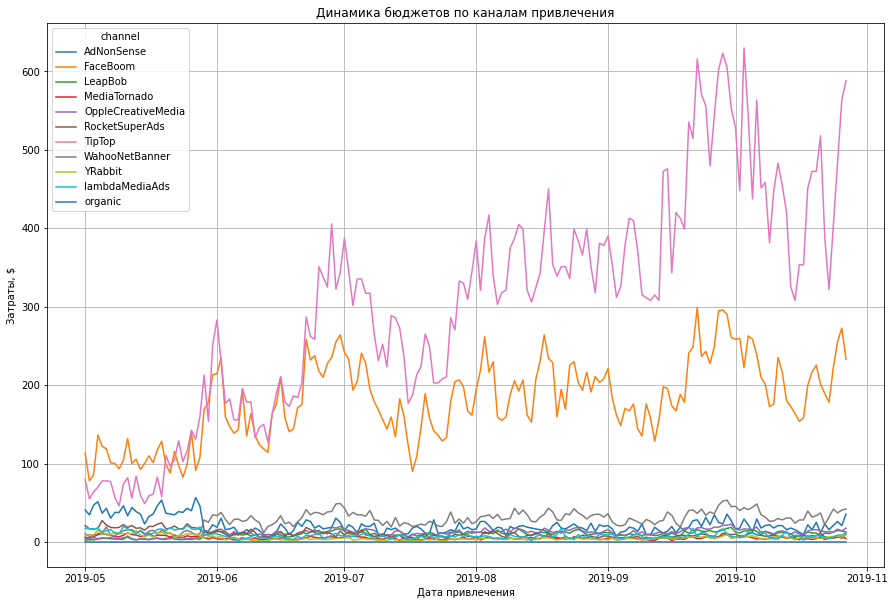

In [26]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('Затраты, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика бюджетов по каналам привлечения')
plt.show()

Вывод: Больше всего потратили на каналы TipTop и FaceBoom (~80% всего бюджета). У канала TipTop средняя стоимость привлечения одного клиента в несколько раз превышает среднюю по остальным.

**Визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику.**

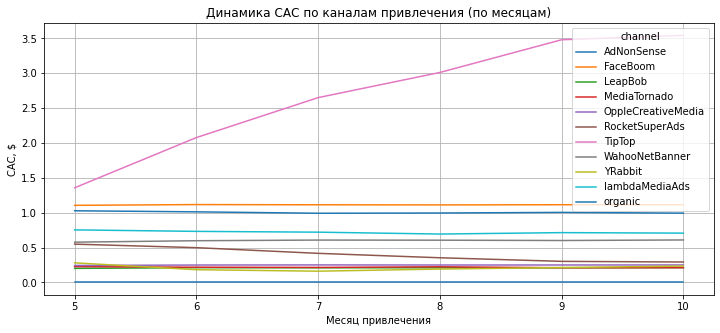

In [27]:
profiles['month'] = pd.DatetimeIndex(profiles['dt']).month

profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(12, 5))
plt.ylabel('CAC, $')
plt.xlabel('Месяц привлечения')
plt.title('Динамика САС по каналам привлечения (по месяцам)')
plt.show()

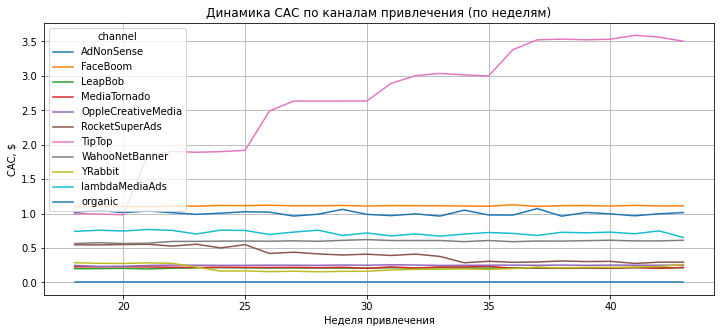

In [28]:
profiles['week'] = pd.to_datetime(profiles['dt']).dt.isocalendar().week

profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(12, 5))
plt.ylabel('CAC, $')
plt.xlabel('Неделя привлечения')
plt.title('Динамика САС по каналам привлечения (по неделям)')
plt.show()

Вывод: Стоимость привлечения пользователей стабильна для всех каналов кроме TipTop, в нём каждый месяц происходит значительное повышение цены.

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Вывод по блоку № 4. 'Маркетинг' :</b>
    
    При анализе маркетинга было выявлено:
    
    Общая сумма расходов на маркетинг: 105497 $
    
    Больше всего потратили на каналы TipTop и FaceBoom (~ 80 % всего бюджета). У канала TipTop средняя стоимость привлечения одного клиента (~ 3 $) в несколько раз превышает среднюю по остальным (~ 1 $).
    
    Стоимость привлечения пользователей стабильна для всех каналов кроме TipTop, в нём каждый месяц происходит значительное повышение цены.

</div>



### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

**Посмотрим окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.**

Уберем пользователей пришедших через канал 'organic' и зададим дату и горизонт анализа:

In [29]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

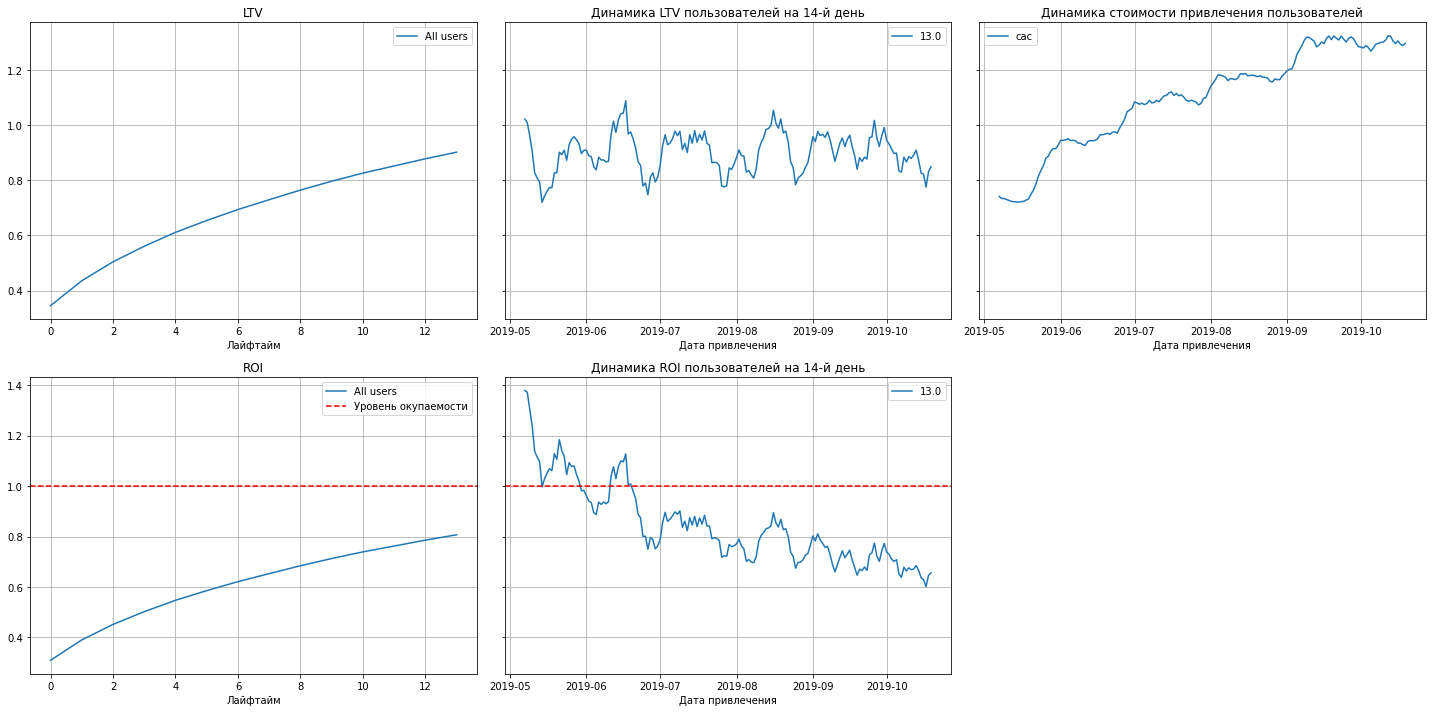

In [30]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Вывод: Реклама не окупается, ROI ~ 80%. По динамике ROI видно что в первом месяце исследования реклама окупался, но дальше график идёт вниз и переходит отметку окупаемости. Скорее всего это связано с повышением цены привлечения пользователей по основному канала FaceBoom (это так же видно на графике динамики стоимости привлечения пользователей).

**Посмотрим удержание, конверсию пользователей и динамику её изменения.**

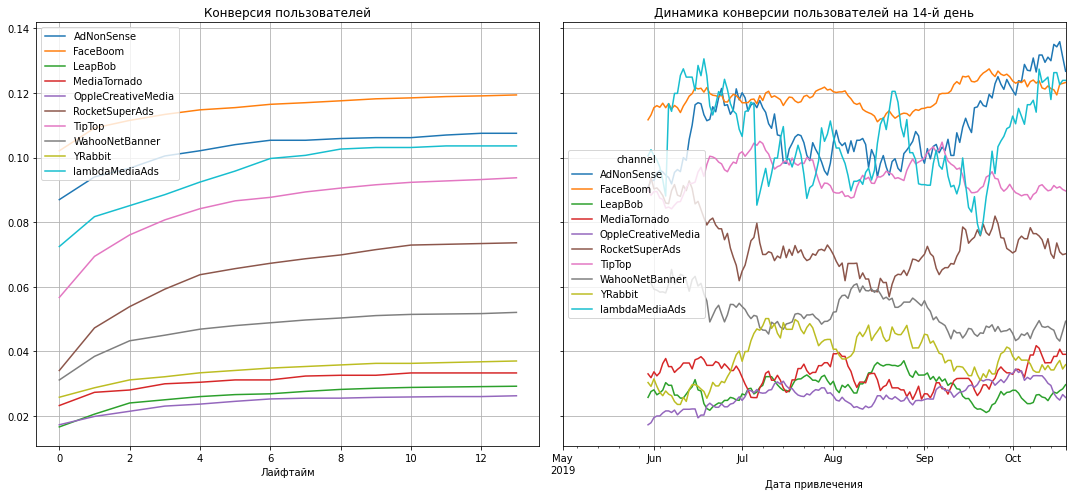

In [31]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30) 

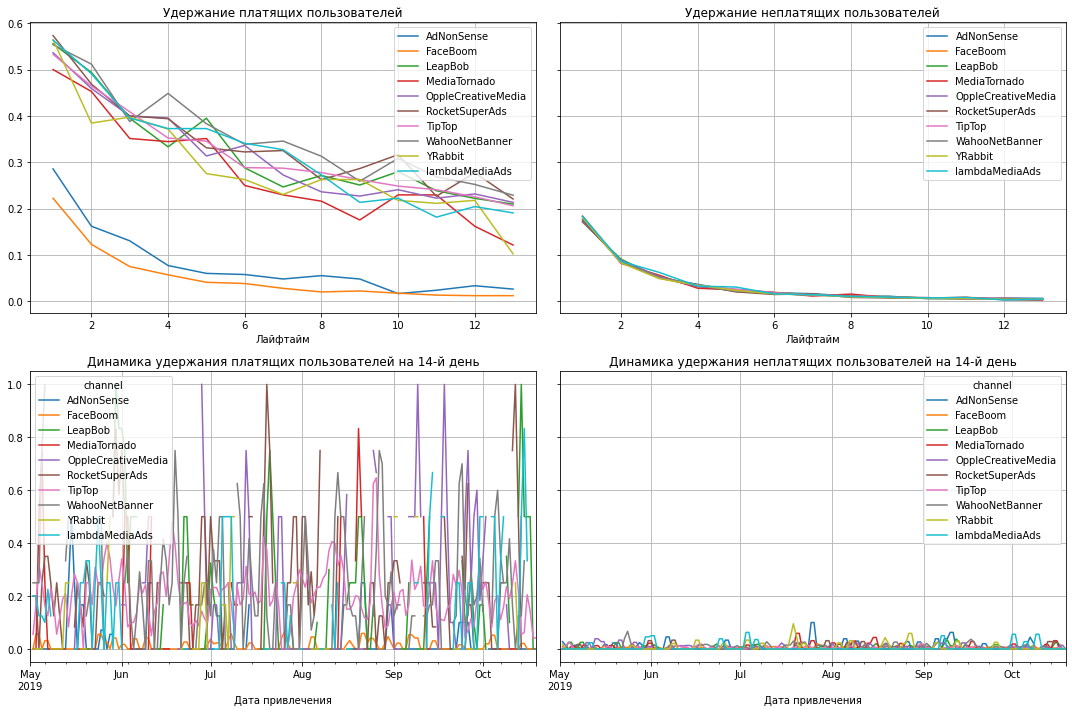

In [32]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=2) 

Вывод: Видим что с конверсией всё хорошо, особенно у FaceBoom (основной канал привлечения). Есть проблемы в удержании пользователей, а именно, отстают два канала FaceBoom и AdNonSense (одни из самых затратных).

**Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

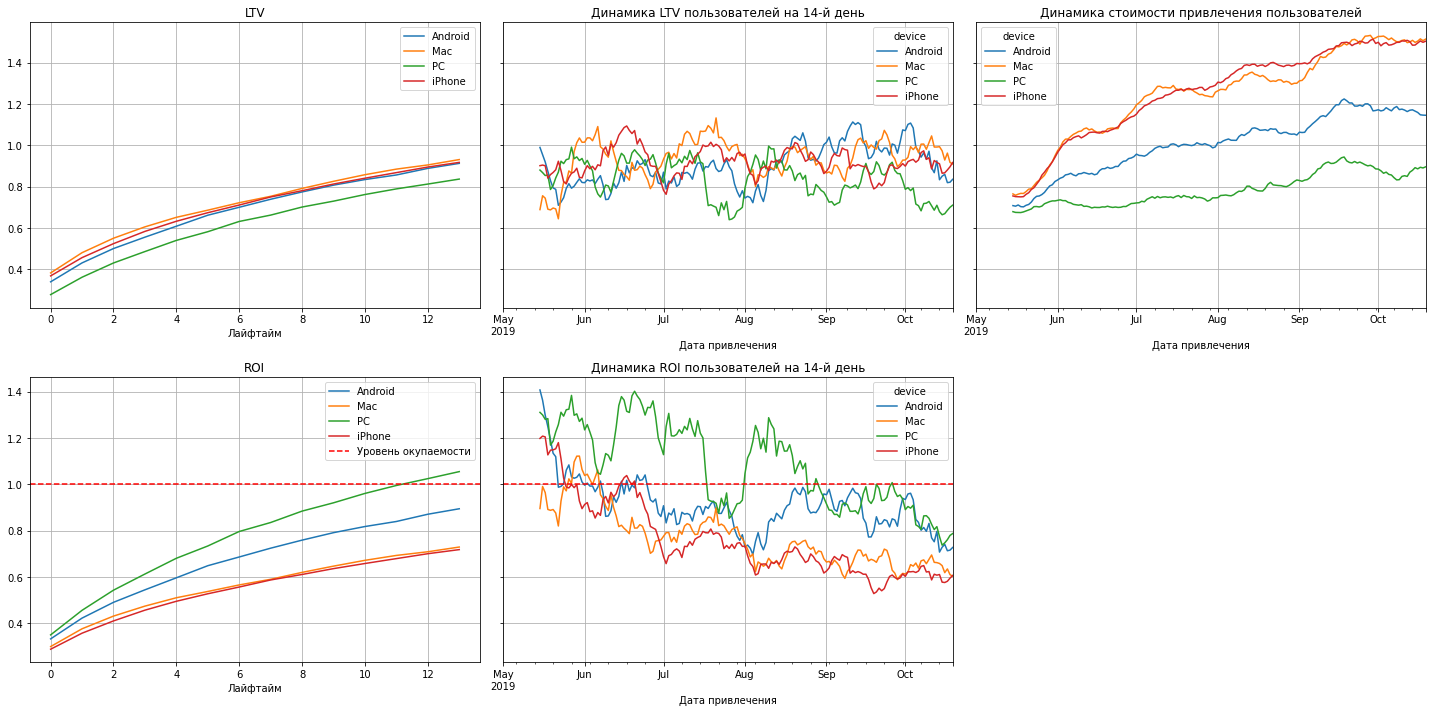

In [33]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=15)

Вывод: LTV у всех устройств в норме. Пользователи со всех устройств перестали сеебя окупать на второй месяц исследования, кроме PC, они держались до сентября. Повышение цены привлечения сказалась на всех.

**Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

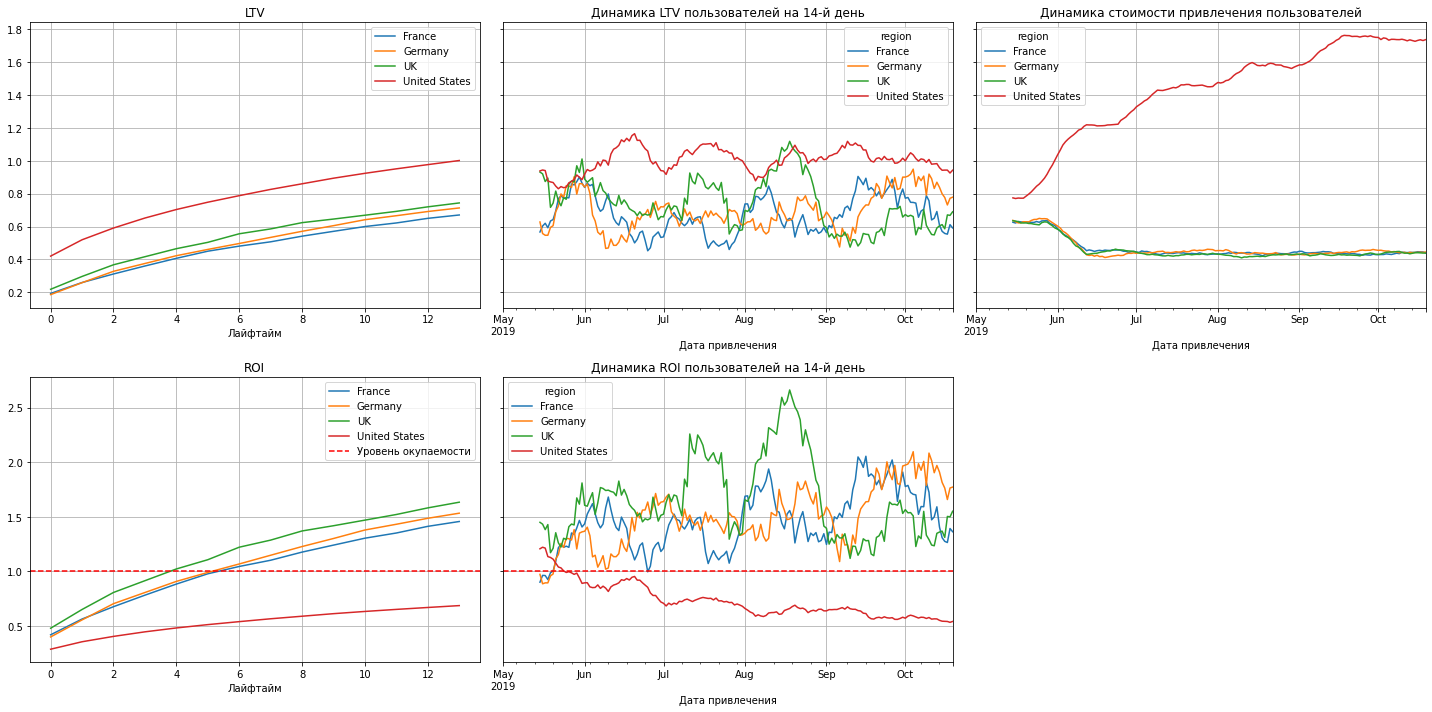

In [34]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=15)

Вывод: Из графиков видим очевидную проблему: стоимость привлечения пользователей растёт только в United States. Так как пользователи из этой страны составляют большую часть клиентов компании, это портит всю картину. ROI остальных стран выше отметки окупаемости.

**Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.**

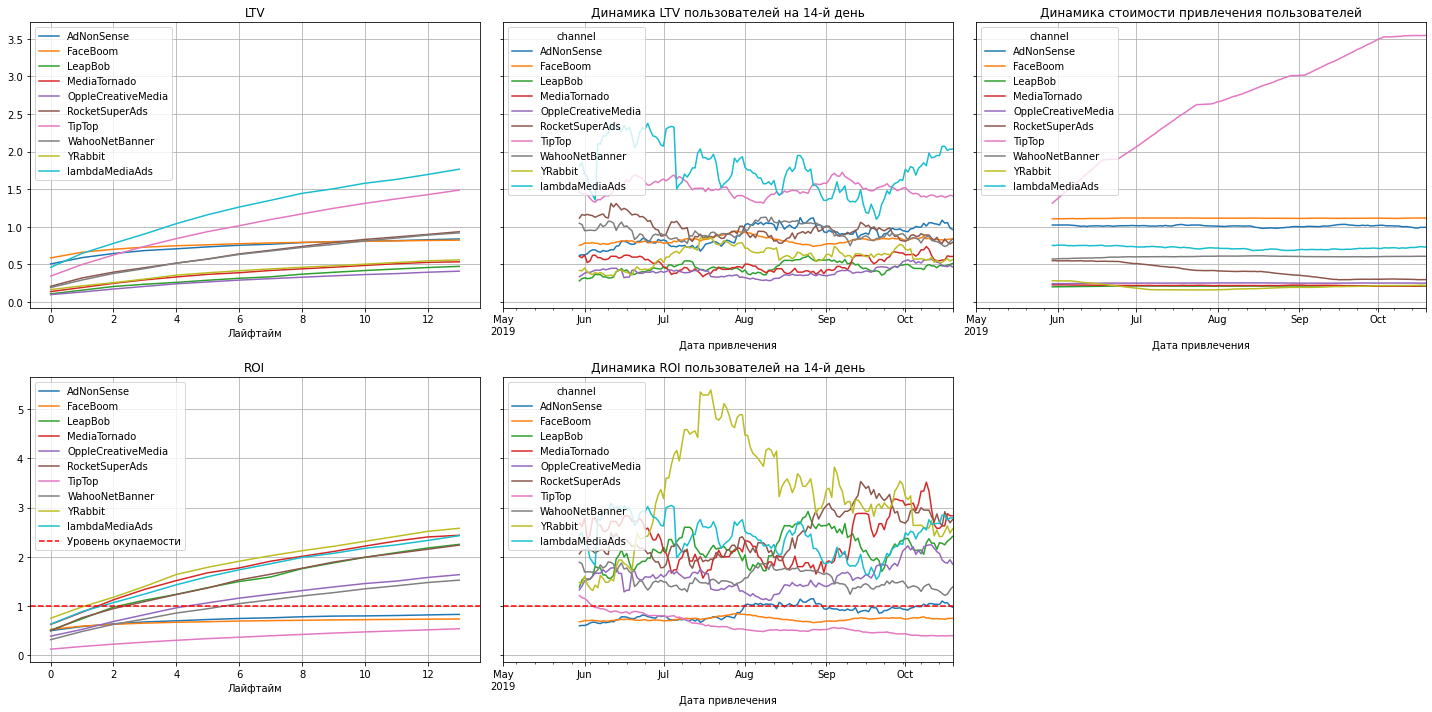

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30)

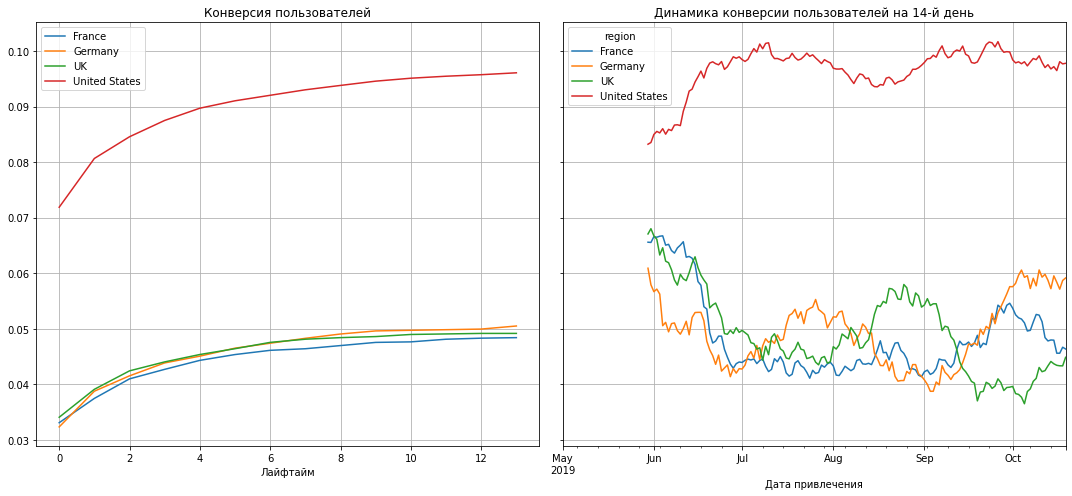

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30) 

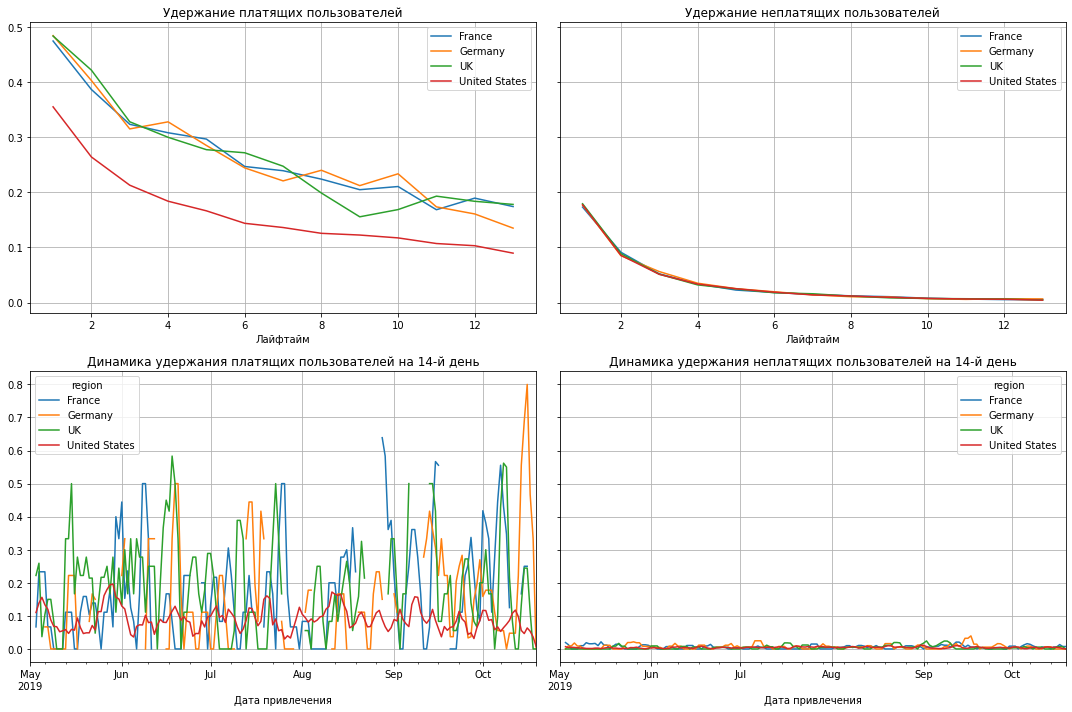

In [37]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=3) 

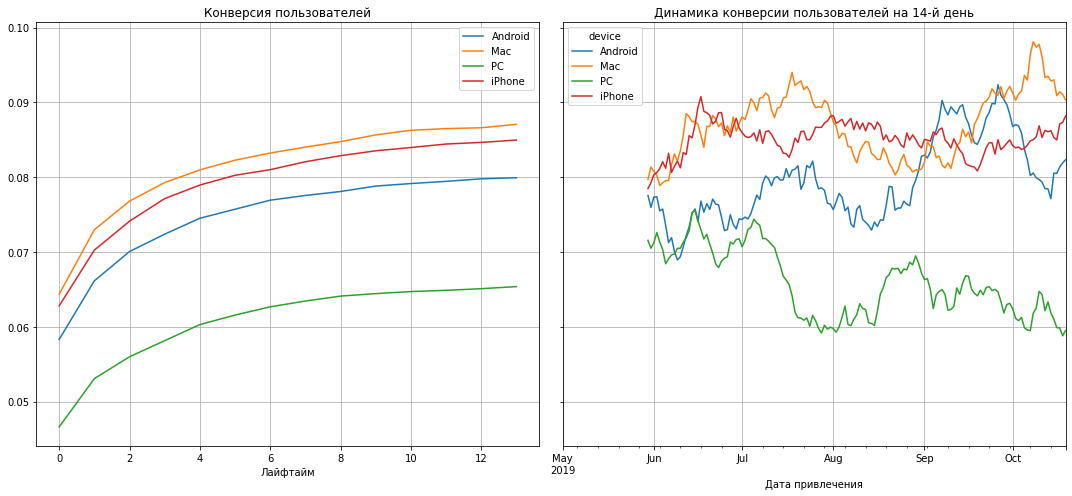

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=30) 

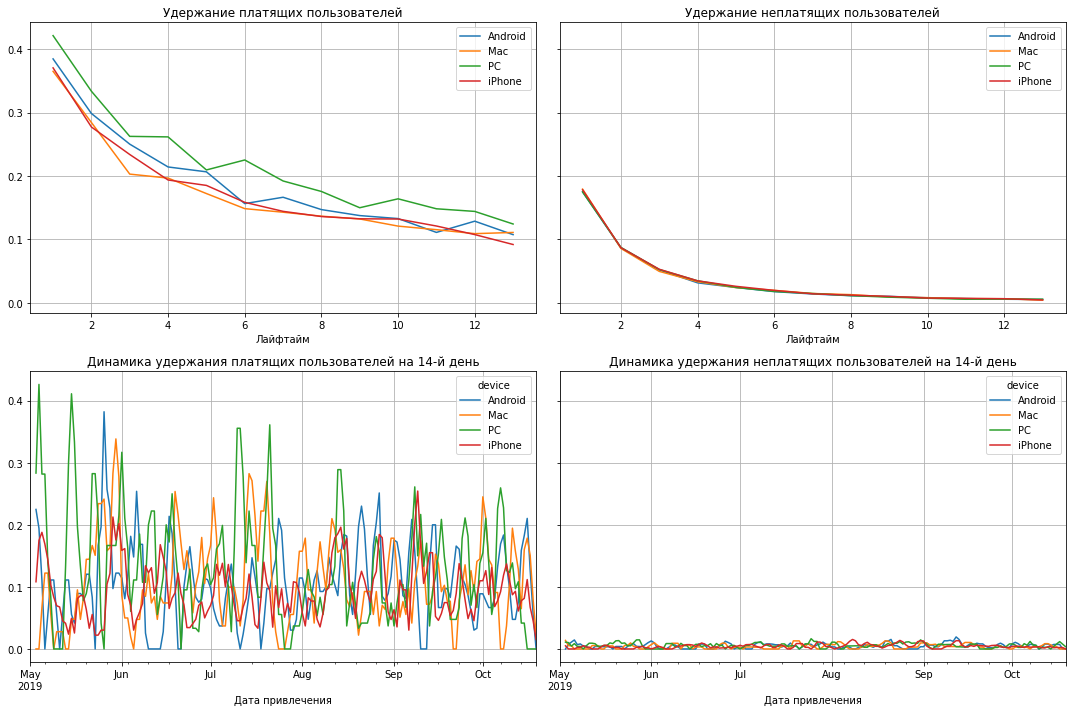

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days, window=3) 

Вывод: Два основных канала (по кол-ву пользователей) FaceBoom и TipTop не окупают вложения в маркетинг. TipTop из-за постоянного повышения цены привлечения, FaceBoom из-за низкого уровня LTV и удержания. Половина каналов имеют ROI выше 200%, отделу маркетинга стоит обратить на них внимание и перенаправить рекламный бюджет в них.

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Вывод по блоку № 5. 'Оценка окупаемости рекламы' :</b>  

    При анализе оценки окупаемости рекламы было выявлено:
    
    Реклама не окупается, ROI ~ 80%. По динамике ROI видно что в первом месяце исследования реклама окупался, но дальше график идёт вниз и переходит отметку окупаемости. Скорее всего это связано с повышением цены привлечения пользователей по основному каналу FaceBoom (это так же видно на графике динамики стоимости привлечения пользователей).
    
    Видим что с конверсией всё хорошо, особенно у FaceBoom (основной канал привлечения). Есть проблемы в удержании пользователей, а именно, отстают два канала FaceBoom и AdNonSense (одни из самых затратных).
    
    LTV у всех устройств в норме. Пользователи со всех устройств перестали сеебя окупать на второй месяц исследования, кроме PC, они держались до сентября. Повышение цены привлечения сказалась на всех.
    
    Стоимость привлечения пользователей растёт только в United States. Так как пользователи из этой страны составляют большую часть клиентов компании, это портит всю картину. ROI остальных стран выше отметки окупаемости.
    
    Два основных канала (по кол-ву пользователей) FaceBoom и TipTop не окупают вложения в маркетинг. TipTop из-за постоянного повышения цены привлечения, FaceBoom из-за низкого уровня LTV и удержания. Половина каналов имеют ROI выше 200%, отделу маркетинга стоит обратить на них внимание и перенаправить рекламный бюджет в них.
   

</div>

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

<div class="alert alert-secondary" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "><b>Итоговый вывод :</b>  

    Причины неэффективности привлечения пользователей:
    Пользователей из Америки больше всего (~ 65 %), у них хорошая конверсия, но реклама не окупается из-за высокой цены привлечения в основном канале TipTop, и так же достаточно высокой цены привлечения и низкого LTV и удержания у FaceBoom. 
    
    Рекомендации для отдела маркетинга:
    - Отказаться от канала привлечения TipTop из-за слишком высокой цены привлечения клиентов.
    - Отказаться от канала привлечения FaceBoom из-за низкого LTV, удержания и относительно высокой цены привлечения.
    - Отказаться от канала привлечения AdNonSense из-за низкого удержания и относительно высокой цены привлечения.
    - Направить рекламный бюджет на каналы которые хорошо окупаются и имееют хорошую конверсию пользователей: lambdaMediaAds и RocketSuperAds.
    - Обратить внимание на канала YRabbit, конверсия у него на очень низком уровне, но за счёт крайне малой стоимости привлечения клиентов он имеет самый высокий ROI.
    - На даннный момент стоимость привлечения пользователей с iPhone и Mac не оправданно дорогая, окупаются только пользователи которые пользуются приложением с PC. Необходимо провести дополнительное исследование по устройствам, после изменения каналов привлечения.
    - Стоит привлекать больше пользователей из Европы 
    
</div>